<a href="https://colab.research.google.com/github/fenyxrainbow/Transfer-Learning/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalação das bibliotecas necessárias
!pip install tensorflow
!pip install keras
!pip install matplotlib

# Importação das bibliotecas
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [4]:
import zipfile

# Caminho para o arquivo .zip
zip_path = '/content/kagglecatsanddogs_5340.zip'

# Diretório onde o conteúdo será extraído
extract_dir = '/content/dataset'

# Descompacta o arquivo .zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Arquivo descompactado com sucesso!")

Arquivo descompactado com sucesso!


In [1]:
import os

# Cria as pastas de treino e teste
os.makedirs('/content/dataset/treino/gatos', exist_ok=True)
os.makedirs('/content/dataset/treino/cachorros', exist_ok=True)
os.makedirs('/content/dataset/teste/gatos', exist_ok=True)
os.makedirs('/content/dataset/teste/cachorros', exist_ok=True)

print("Pastas criadas com sucesso!")

Pastas criadas com sucesso!


In [5]:
import shutil
import os

# Caminho das pastas originais
cat_dir = '/content/dataset/PetImages/Cat'
dog_dir = '/content/dataset/PetImages/Dog'

# Caminho das pastas de treino e teste
train_cat_dir = '/content/dataset/treino/gatos'
train_dog_dir = '/content/dataset/treino/cachorros'
test_cat_dir = '/content/dataset/teste/gatos'
test_dog_dir = '/content/dataset/teste/cachorros'

# Função para mover as imagens
def move_images(source_dir, train_dir, test_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    split_index = int(len(files) * split_ratio)

    # Move as imagens para a pasta de treino
    for file in files[:split_index]:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))

    # Move as imagens para a pasta de teste
    for file in files[split_index:]:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))

# Move as imagens de gatos
move_images(cat_dir, train_cat_dir, test_cat_dir)

# Move as imagens de cachorros
move_images(dog_dir, train_dog_dir, test_dog_dir)

print("Imagens movidas com sucesso!")

Imagens movidas com sucesso!


In [7]:
import shutil

# Exclui a pasta PetImages
shutil.rmtree('/content/dataset/PetImages')

print("Pasta PetImages excluída com sucesso!")

Pasta PetImages excluída com sucesso!


In [8]:
# Caminho para o dataset
dataset_dir = '/content/dataset'

# Configuração do ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalização dos pixels
    validation_split=0.2,  # 20% dos dados para validação
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Geradores para treino e validação
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # Redimensionamento das imagens
    batch_size=32,
    class_mode='binary',  # Duas classes: gatos e cachorros
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 20001 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


In [9]:
# Carregamento do modelo pré-treinado MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,  # Removemos as camadas densas do topo
    weights='imagenet'  # Pesos pré-treinados no ImageNet
)

# Congelamos as camadas do modelo base para não atualizá-las durante o treinamento
base_model.trainable = False

# Adicionamos camadas personalizadas no topo do modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduz a dimensionalidade
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularização para evitar overfitting
    layers.Dense(1, activation='sigmoid')  # Saída binária
])

# Compilação do modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()

<ipython-input-9-162825628d7e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import shutil

# ... (rest of your code before ImageDataGenerator) ...

# Function to validate images and remove invalid ones
def validate_images(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            # Attempt to open the image using Pillow
            img = Image.open(filepath)
            # Verify image format (optional)
            # img.verify()  # This line can be overly strict, causing valid images to be removed
            img.close()  # Close the image file to release resources
        except (IOError, SyntaxError, ValueError) as e:
            print(f"Removing invalid image: {filepath} - Error: {e}")
            os.remove(filepath)  # Remove the invalid image

# Validate images in training and validation directories
for directory in [train_cat_dir, train_dog_dir, test_cat_dir, test_dog_dir]:
    validate_images(directory)

# ... (continue with ImageDataGenerator and model training) ...

# Re-create the generators after validating and potentially removing images
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),  # Redimensionamento das imagens
    batch_size=32,
    class_mode='binary',  # Duas classes: gatos e cachorros
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Treinamento do modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Found 19999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 636s 1s/step - accuracy: 0.8026 - loss: 0.5170 - val_accuracy: 0.7999 - val_loss: 0.5058
Epoch 2/10
  1/624 ━━━━━━━━━━━━━━━━━━━━ 5:38 544ms/step - accuracy: 0.7500 - loss: 0.5707

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


624/624 ━━━━━━━━━━━━━━━━━━━━ 127s 202ms/step - accuracy: 0.7500 - loss: 0.5707 - val_accuracy: 0.7997 - val_loss: 0.5077
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.7971 - loss: 0.5132 - val_accuracy: 0.8003 - val_loss: 0.5031
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.7188 - loss: 0.6353 - val_accuracy: 0.8001 - val_loss: 0.5042
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.8019 - loss: 0.5065 - val_accuracy: 0.8003 - val_loss: 0.5029
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 132s 210ms/step - accuracy: 0.7812 - loss: 0.5186 - val_accuracy: 0.7999 - val_loss: 0.5027
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.7978 - loss: 0.5096 - val_accuracy: 0.7999 - val_loss: 0.5037
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 129s 206ms/step - accuracy: 0.8750 - loss: 0.3984 - val_accuracy: 0.8001 - val_loss: 0.5027
Epoch 9/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.7975 - loss: 0.5086 - val_acc

In [13]:
# Treinamento do modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
115/625 ━━━━━━━━━━━━━━━━━━━━ 6:50 805ms/step - accuracy: 0.7856 - loss: 0.5418

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/treino/gatos/666.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 235, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/treino/gatos/666.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_8671]

157/157 ━━━━━━━━━━━━━━━━━━━━ 126s 799ms/step - accuracy: 0.8034 - loss: 0.4997
Acurácia no conjunto de validação: 80.00%


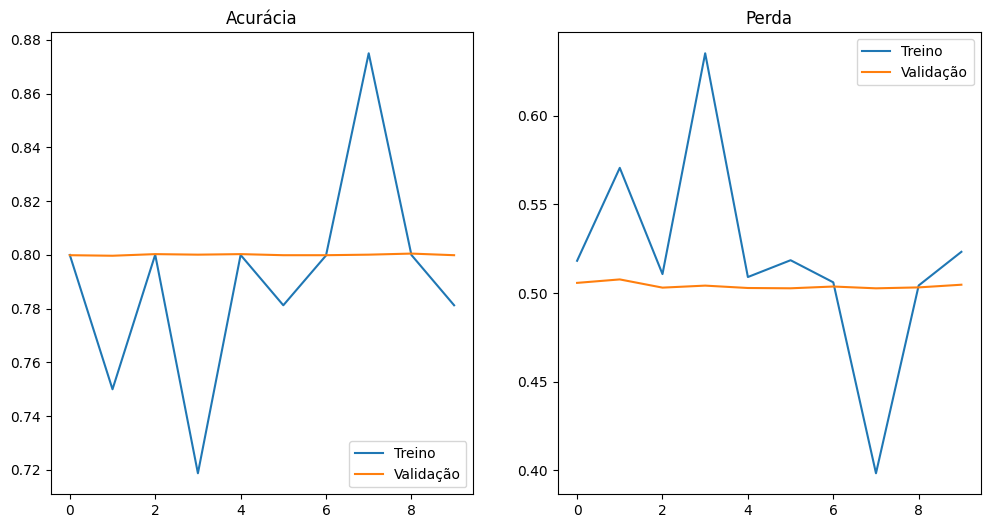

In [15]:
# Avaliação do modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")

# Plotagem das curvas de aprendizado
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Perda')
plt.show()